## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

<>:3: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3092293347.py:3: SyntaxWarning: invalid escape sequence '\g'
  Implements linear transform of input y = \gamma * x + \beta


# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

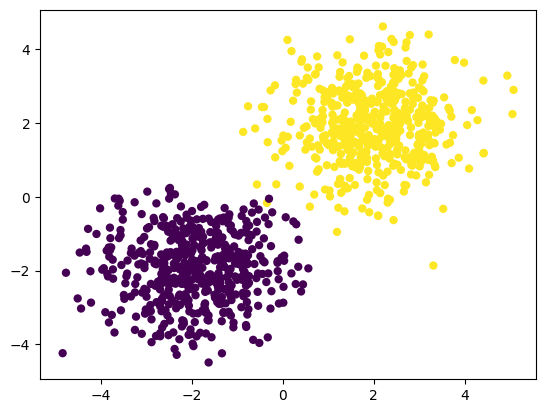

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [4]:
#net = Sequential()
#net.add(Linear(2, 2))
#net.add(LogSoftMax())

criterion = ClassNLLCriterion()

#print(net)

# Test something like that then

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

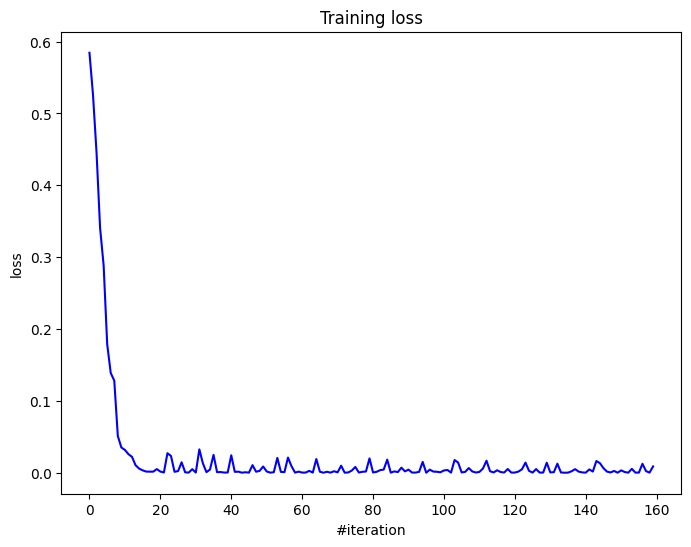

Current loss: 0.008820


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [8]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

--2025-12-15 16:36:11--  https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [text/plain]
Saving to: ‘mnist.py’

mnist.py            100%[===================>]   2.63K  --.-KB/s    in 0s      

2025-12-15 16:36:11 (46.3 MB/s) - ‘mnist.py’ saved [2697/2697]



In [9]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')

X = X.astype('float32') / 255.0
y = y.astype('int')


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42, stratify=y_train_val
)


One-hot encode the labels first.

In [10]:
n_classes = 10

def to_one_hot(y, num_classes=n_classes):
    y = np.asarray(y, dtype=int).ravel()
    out = np.zeros((y.size, num_classes), dtype=np.float32)
    out[np.arange(y.size), y] = 1.0
    return out

y_train_oh = to_one_hot(y_train, n_classes)
y_val_oh   = to_one_hot(y_val,   n_classes)
y_test_oh  = to_one_hot(y_test,  n_classes)



- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

Training ReLU...
Training ELU...
Training LeakyReLU...
Training SoftPlus...
Training ReLU + BN...
Training Adam (ReLU)...


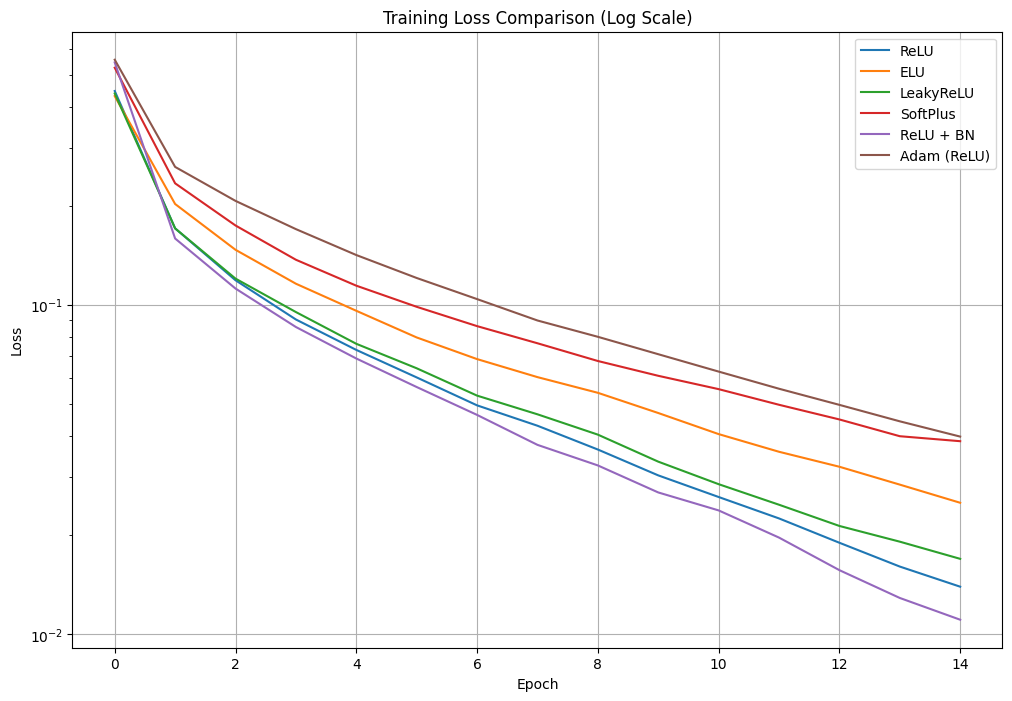

In [11]:

if hasattr(X_train, 'to_numpy'):
    X_train = X_train.to_numpy()
if hasattr(X_val, 'to_numpy'):
    X_val = X_val.to_numpy()
if hasattr(X_test, 'to_numpy'):
    X_test = X_test.to_numpy()

if hasattr(y_train, 'to_numpy'):
    y_train = y_train.to_numpy()
if hasattr(y_val, 'to_numpy'):
    y_val = y_val.to_numpy()
if hasattr(y_test, 'to_numpy'):
    y_test = y_test.to_numpy()

def train_model(net, optimizer, config, X, y, X_val, y_val, n_epochs=10, batch_size=128):
    loss_history = []
    val_loss_history = []

    optimizer_state = {}

    opt_config = config.copy()

    criterion = ClassNLLCriterion()

    for i in range(n_epochs):
        net.train()
        epoch_loss = 0
        num_batches = 0

        for x_batch, y_batch in get_batches((X, y), batch_size):
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update
            optimizer(net.getParameters(),
                      net.getGradParameters(),
                      opt_config,
                      optimizer_state)

            epoch_loss += loss
            num_batches += 1

        loss_history.append(epoch_loss / num_batches)

        # Validation
        net.evaluate()
        val_pred = net.forward(X_val)
        val_loss = criterion.forward(val_pred, y_val)
        val_loss_history.append(val_loss)

    return loss_history, val_loss_history

def get_linear_model(activation):
    net = Sequential()
    net.add(Linear(784, 128))
    net.add(activation)
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

def get_bn_model():
    net = Sequential()
    net.add(Linear(784, 128))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(128))
    net.add(ReLU())
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

models_to_train = [
    ("ReLU", get_linear_model(ReLU()), sgd_momentum),
    ("ELU", get_linear_model(ELU()), sgd_momentum),
    ("LeakyReLU", get_linear_model(LeakyReLU()), sgd_momentum),
    ("SoftPlus", get_linear_model(SoftPlus()), sgd_momentum),
    ("ReLU + BN", get_bn_model(), sgd_momentum),
    ("Adam (ReLU)", get_linear_model(ReLU()), adam_optimizer)
]

results = {}
optimizer_config = {'learning_rate': 1e-1, 'momentum': 0.9}
adam_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}

plt.figure(figsize=(12, 8))

for name, net, opt in models_to_train:
    print(f"Training {name}...")

    current_config = adam_config if opt == adam_optimizer else optimizer_config

    loss, val_loss = train_model(net, opt, current_config, X_train, y_train_oh, X_val, y_val_oh,
                                 n_epochs=15, batch_size=256)
    results[name] = loss
    plt.plot(loss, label=name)

plt.title("Training Loss Comparison (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [12]:
# Your answer goes here. ################################################

По графику видно, что ReLU и LeakyReLU справляются лучше всех,
так как ошибка падает быстрее всего.
С точки зрения скорости вычислений ReLU тоже выигрывает, потому что ее просто
вычислить, а в ELU и SoftPlus используются экспоненты и логарифмы.
Обычный ReLU быстрый и эффективный.
Насчет батч-нормализации, она точно помогает.
Фиолетовая линия с BN идет ниже всех с самого начала.
Она улучшает обучение, поэтому сеть учится точнее,
что с перекрывает затраты на дополнительные вычисления на каждом шаге.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Flatten
Linear 784 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 512 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 256 -> 10
LogSoftMax

ЭПоха 1/20 | Loss 258.21759173668966 | Train Acc: 0.86616 | Val Acc: 0.9601
ЭПоха 2/20 | Loss 68.13938289846885 | Train Acc: 0.94952 | Val Acc: 0.9727
ЭПоха 3/20 | Loss 52.722789665148454 | Train Acc: 0.95922 | Val Acc: 0.9747
ЭПоха 4/20 | Loss 43.15304794513349 | Train Acc: 0.96606 | Val Acc: 0.9778
ЭПоха 5/20 | Loss 38.52764814225904 | Train Acc: 0.969 | Val Acc: 0.9794
ЭПоха 6/20 | Loss 34.97771371935563 | Train Acc: 0.9723 | Val Acc: 0.9809
ЭПоха 7/20 | Loss 31.836497697833646 | Train Acc: 0.97446 | Val Acc: 0.9798
ЭПоха 8/20 | Loss 30.443450601863685 | Train Acc: 0.9754 | Val Acc: 0.9825
ЭПоха 9/20 | Loss 29.328165361212875 | Train Acc: 0.97646 | Val Acc: 0.9818
ЭПоха 10/20 | Loss 26.955873254520203 | Train Acc: 0.9778 | Val Acc: 0.9818
ЭПоха 11/20 | Loss 21.12932056903686 | Train Acc: 0.98318 | Val Acc: 0.98

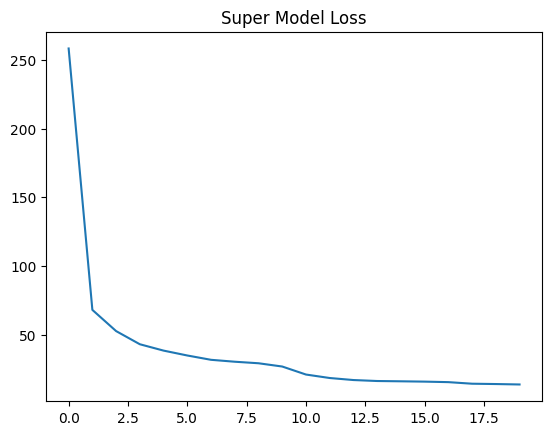

In [16]:

model = Sequential()
model.add(Flatten())
model.add(Linear(784, 512))
model.add(BatchNormalization(alpha=0.9))
model.add(ChannelwiseScaling(512))
model.add(ReLU())
model.add(Dropout(p=0.5))

model.add(Linear(512, 256))
model.add(BatchNormalization(alpha=0.9))
model.add(ChannelwiseScaling(256))
model.add(ReLU())
model.add(Dropout(p=0.5))

model.add(Linear(256, 10))
model.add(LogSoftMax())

print(model)

criterion = ClassNLLCriterion()
optimizer_state = {}
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
batch_size = 128
n_epochs = 20

loss_history = []
train_acc_history = []
val_acc_history = []

for i in range(n_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    if i == 10:
        optimizer_config['learning_rate'] *= 0.1

    for x_batch, y_batch in get_batches((X_train, y_train_oh), batch_size):
        model.zeroGradParameters()

        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        dp = criterion.backward(predictions, y_batch)
        model.backward(x_batch, dp)

        adam_optimizer(model.getParameters(),
                       model.getGradParameters(),
                       optimizer_config,
                       optimizer_state)

        epoch_loss += loss

        pred_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(y_batch, axis=1)
        correct += np.sum(pred_labels == true_labels)
        total += pred_labels.shape[0]

    loss_history.append(epoch_loss)
    train_acc = correct / total
    train_acc_history.append(train_acc)

    model.evaluate()
    val_pred = model.forward(X_val)
    val_labels = np.argmax(val_pred, axis=1)
    true_val_labels = np.argmax(y_val_oh, axis=1)
    val_acc = np.sum(val_labels == true_val_labels) / y_val_oh.shape[0]
    val_acc_history.append(val_acc)

    print(f"ЭПоха {i+1}/{n_epochs} | Loss {epoch_loss} | Train Acc: {train_acc} | Val Acc: {val_acc}")

plt.plot(loss_history)
plt.title("Super Model Loss")
plt.show()

Print here your accuracy on test set. It should be around 90%.

In [17]:
# Your answer goes here. ################################################
model.evaluate()
test_predictions = model.forward(X_test)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(y_test_oh, axis=1)

accuracy = np.sum(test_pred_labels == test_true_labels) / X_test.shape[0]
print(f" конечный аccuracy: {accuracy * 100}%")

 конечный аccuracy: 98.39%


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

class PyTorchModel(nn.Module):
    def __init__(self):
        super(PyTorchModel, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 10)

        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch_model = PyTorchModel().to(device)

optimizer = optim.Adam(torch_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

n_epochs = 10

for epoch in range(n_epochs):
    torch_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = torch_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Эпоха {epoch+1}, Loss {running_loss / len(train_loader)}")

torch_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"аccuracy: {100 * correct / total}%")

Эпоха 1, Loss 0.3465088260410082
Эпоха 2, Loss 0.18078783173542803
Эпоха 3, Loss 0.14230873683453216
Эпоха 4, Loss 0.12192162474059998
Эпоха 5, Loss 0.10737412411462316
Эпоха 6, Loss 0.10089775609314594
Эпоха 7, Loss 0.0913528419811936
Эпоха 8, Loss 0.08271716170660827
Эпоха 9, Loss 0.0771999763744071
Эпоха 10, Loss 0.0741404896778295
аccuracy: 98.07%
